In [2]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin

# # SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder
from generative_models.sgm.models.diffusion import DiffusionEngine
from omegaconf import OmegaConf

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils
from torchmetrics import PearsonCorrCoef
from torchvision.utils import make_grid
from models import *
os.chdir("../")


/export/raid1/home/kneel027/miniconda3/envs/mindeye_clone/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda:1"

In [4]:
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

# ## UNCOMMENT BELOW SECTION AND COMMENT OUT DEEPSPEED SECTION TO AVOID USING DEEPSPEED ###
# use_deepspeed = False
# accelerator = Accelerator(split_batches=False, mixed_precision="fp16") # ['no', 'fp8', 'fp16', 'bf16']
# global_batch_size = batch_size = 16

### DEEPSPEED INITIALIZATION ###
use_deepspeed = True
import deepspeed
num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1
if num_devices <= 1 and utils.is_interactive():
    global_batch_size = batch_size = 16
    print(f"Setting batch_size to {batch_size}")
    # can emulate a distributed environment for deepspeed to work in jupyter notebook
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = str(np.random.randint(10000)+9000)
    os.environ["RANK"] = "0"
    os.environ["LOCAL_RANK"] = "0"
    os.environ["WORLD_SIZE"] = "1"
    os.environ["GLOBAL_BATCH_SIZE"] = str(global_batch_size) # set this to your batch size!
else:
    global_batch_size = batch_size = 16 
    os.environ["GLOBAL_BATCH_SIZE"] = str(global_batch_size)
    batch_size = int(os.environ["GLOBAL_BATCH_SIZE"]) // num_devices
    if num_devices <= 1:
        os.environ["RANK"] = "0"
        os.environ["LOCAL_RANK"] = "0"
        os.environ["WORLD_SIZE"] = "1"

# alter the deepspeed config according to your global and local batch size
if local_rank == 0:
    with open('deepspeed_config_stage2_cpuoffload.json', 'r') as file:
        config = json.load(file)
    config['train_batch_size'] = int(os.environ["GLOBAL_BATCH_SIZE"])
    config['train_micro_batch_size_per_gpu'] = batch_size
    config['bf16'] = {'enabled': False}
    config['fp16'] = {'enabled': True}
    with open('deepspeed_config_stage2_cpuoffload.json', 'w') as file:
        json.dump(config, file)
else:
    # give some time for the local_rank=0 gpu to prep new deepspeed config file
    time.sleep(10)
deepspeed_plugin = DeepSpeedPlugin("deepspeed_config_stage2_cpuoffload.json")
accelerator = Accelerator(split_batches=False, deepspeed_plugin=deepspeed_plugin)

/export/raid1/home/kneel027/miniconda3/envs/mindeyev2/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


LOCAL RANK  0


In [5]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
num_devices = torch.cuda.device_count()
if num_devices==0 or not distributed: num_devices = 1
num_workers = num_devices
print(accelerator.state)

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)
print = accelerator.print # only print if local_rank=0

PID of this process = 123515
device: cpu
Distributed environment: DistributedType.DEEPSPEED
Num processes: 1
Process index: 0
Local process index: 0
Device: cpu

Mixed precision type: fp16
ds_config: {'bf16': {'enabled': False}, 'fp16': {'enabled': True}, 'zero_optimization': {'stage': 2, 'contiguous_gradients': True, 'stage3_gather_16bit_weights_on_model_save': True, 'stage3_max_live_parameters': 1000000000.0, 'stage3_max_reuse_distance': 1000000000.0, 'stage3_prefetch_bucket_size': 10000000.0, 'stage3_param_persistence_threshold': 100000.0, 'reduce_bucket_size': 10000000.0, 'sub_group_size': 1000000000.0, 'offload_optimizer': {'device': 'cpu', 'nvme_path': '/scratch', 'pin_memory': True}, 'offload_param': {'device': 'none', 'nvme_path': '/scratch', 'buffer_size': 4000000000.0, 'pin_memory': True}}, 'aio': {'block_size': 26214400, 'queue_depth': 32, 'thread_count': 1, 'single_submit': False, 'overlap_events': True}, 'gradient_accumulation_steps': 1, 'gradient_clipping': 1.0, 'steps_pe

In [4]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "unCLIP_8gpu_noblur_nodepth"
    print("model_name:", model_name)

    # global_batch_size and batch_size should already be defined in the above cells
    # other variables can be specified in the following string:
    jupyter_args = f"--data_path=dataset \
                    --model_name={model_name} \
                    --subj=1 --subj_list=1 --num_sessions=37 \
                    --hidden_dim=2048 --seq_len=1"
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: unCLIP_8gpu_noblur_nodepth
--data_path=dataset                     --model_name=unCLIP_8gpu_noblur_nodepth                     --subj=1 --subj_list=1 --num_sessions=37                     --hidden_dim=2048 --seq_len=1


In [5]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default="/fsx/proj-fmri/shared/natural-scenes-dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
    help="Validate on which subject?",
)
parser.add_argument(
    "--num_sessions", type=int, default=0,
    help="Number of training sessions to include (zero = all sessions)",
)
parser.add_argument(
    "--subj_list", type=int, nargs='+', default=[2,3,4,5,6,7,8],
    help="number of subjects"
)
parser.add_argument(
    "--n_blocks",type=int,default=4,
)
parser.add_argument(
    "--hidden_dim",type=int,default=4096,
)
parser.add_argument(
    "--seq_len",type=int,default=1,
)
parser.add_argument(
    "--seed",type=int,default=42,
)
if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)
outdir = os.path.abspath(f'../train_logs/{model_name}')
print("subj_list", subj_list, "num_sessions", num_sessions)

subj_list [1] num_sessions 37


In [7]:
def my_split_by_node(urls): return urls

voxels = {}
# Load hdf5 data for betas
f = h5py.File(f'{data_path}/betas_all_subj0{subj}_fp32_renorm.hdf5', 'r')
betas = f['betas'][:]
betas = torch.Tensor(betas).to("cpu")
num_voxels = betas[0].shape[-1]
voxels[f'subj0{subj}'] = betas
print(f"num_voxels for subj0{subj}: {num_voxels}")
print(num_sessions)
if num_sessions==37: # using old test set from before full dataset released (used in original MindEye paper)
    if subj==3:
        num_test=2113
    elif subj==4:
        num_test=1985
    elif subj==6:
        num_test=2113
    elif subj==8:
        num_test=1985
    else:
        num_test=2770
    test_url = f"{data_path}/wds/subj0{subj}/test/" + "0.tar"
else: # using larger test set from after full dataset released
    if subj==3:
        num_test=2371
    elif subj==4:
        num_test=2188
    elif subj==6:
        num_test=2371
    elif subj==8:
        num_test=2188
    else:
        num_test=3000
    test_url = f"{data_path}/wds/subj0{subj}/new_test/" + "0.tar"
    
print(test_url)
test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=num_test, shuffle=False, drop_last=True, pin_memory=True)
print(f"Loaded test dl for subj{subj}!\n")

num_voxels for subj01: 15724
37
dataset/wds/subj01/test/0.tar
Loaded test dl for subj1!



In [8]:
# Prep images but don't load them all to memory
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images']

# Prep test voxels and indices of test images
test_images_idx = []
for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):
    test_voxels = voxels[f'subj0{subj}'][behav[:,0,5].cpu().long()]
    test_images_idx = np.append(test_images_idx, behav[:,0,0].cpu().numpy())
test_images_idx = test_images_idx.astype(int)

assert (test_i+1) * num_test == len(test_voxels) == len(test_images_idx)
print(test_i, len(test_voxels), len(test_images_idx), len(np.unique(test_images_idx)))

0 2770 2770 982


# Load models

In [26]:
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    version="laion2b_s39b_b160k",
    output_tokens=True,
    only_tokens=True,
)
clip_img_embedder.to(device)

clip_seq_dim = 256
clip_emb_dim = 1664

In [7]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()

class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_sizes, out_features, seq_len): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
        self.temp = nn.Parameter(torch.Tensor([5.3]))
        self.bias = nn.Parameter(torch.Tensor([-2.]))
    def forward(self, x, subj_idx):
        out = torch.cat([self.linears[subj_idx](x[:,seq]).unsqueeze(1) for seq in range(seq_len)], dim=1)
        return out
        
model.ridge = RidgeRegression(num_voxels_list, out_features=hidden_dim, seq_len=seq_len)

class BrainNetwork(nn.Module):
    def __init__(self, out_dim=768, in_dim=15724, seq_len=2, h=4096, n_blocks=n_blocks, drop=.15, 
                 clip_size=768, text_clip_size=768, text_out_dim=768):
        super().__init__()
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size
        self.text_clip_size = text_clip_size
        
        # Mixer Blocks
        self.mixer_ln1 = nn.ModuleList([
            self.ln(h) for _ in range(n_blocks)
        ])
        self.mixer_blocks1 = nn.ModuleList([
            self.mlp(seq_len, seq_len, drop) for _ in range(n_blocks)
        ])
        self.mixer_ln2 = nn.ModuleList([
            self.ln(h) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mlp(h, h, drop) for _ in range(n_blocks)
        ])
        
        # Output linear layer
        self.clin1 = nn.Linear(h * seq_len, out_dim, bias=True)
        self.clip_proj = self.projector(clip_size, clip_size)
            
    def projector(self, in_dim, out_dim):
        return nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.GELU(),
            nn.Linear(in_dim, 2048),
            nn.LayerNorm(2048),
            nn.GELU(),
            nn.Linear(2048, 2048),
            nn.LayerNorm(2048),
            nn.GELU(),
            nn.Linear(2048, out_dim)
        )
    
    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )

    def ln(self, dim):
        return nn.LayerNorm(dim)
        
    def forward(self, x):
        # make empty tensors for blur and depth outputs
        t,b,d = torch.Tensor([0.]), torch.Tensor([0.]), torch.Tensor([0.])
        
        # Mixer blocks
        residual1 = x.permute(0,2,1)
        residual2 = x
        for ln1, block1, ln2, block2 in zip(self.mixer_ln1, self.mixer_blocks1, self.mixer_ln2, self.mixer_blocks2):
            # Layer norm before transpose
            x = ln1(x)
            x = x.permute(0,2,1)
            
            # Channel mixing
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)
            
            # Embedding mixing
            x = ln2(x)
            x = block2(x) + residual2
            residual2 = x
        
        # Flatten
        x = x.reshape(x.size(0), -1)
        backbone = self.clin1(x).reshape(len(x), -1, self.clip_size)
        c = self.clip_proj(backbone)
        
        return backbone, c

model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=seq_len, 
                          clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim) 
utils.count_params(model.ridge)
utils.count_params(model.backbone)
utils.count_params(model)

NameError: name 'num_voxels_list' is not defined

## Diffusion Prior

In [29]:
# setup diffusion prior network
out_dim = clip_emb_dim
depth = 6
dim_head = 52
heads = clip_emb_dim//52 # heads * dim_head = clip_emb_dim
timesteps = 100

prior_network = VersatileDiffusionPriorNetwork(
        dim=out_dim,
        depth=depth,
        dim_head=dim_head,
        heads=heads,
        causal=False,
        num_tokens = clip_seq_dim,
        learned_query_mode="pos_emb"
    )

model.diffusion_prior = BrainDiffusionPrior(
    net=prior_network,
    image_embed_dim=out_dim,
    condition_on_text_encodings=False,
    timesteps=timesteps,
    cond_drop_prob=0.2,
    image_embed_scale=None,
    voxel2clip=None,
)
utils.count_params(model.diffusion_prior)
utils.count_params(model)

param counts:
259,865,216 total
259,865,200 trainable
param counts:
259,865,216 total
259,865,200 trainable


259865200

## Prep unCLIP

In [32]:
config = OmegaConf.load("src/generative_models/configs/unclip6.yaml")
config = OmegaConf.to_container(config, resolve=True)
unclip_params = config["model"]["params"]
network_config = unclip_params["network_config"]
denoiser_config = unclip_params["denoiser_config"]
first_stage_config = unclip_params["first_stage_config"]
conditioner_config = unclip_params["conditioner_config"]
sampler_config = unclip_params["sampler_config"]
scale_factor = unclip_params["scale_factor"]
disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]

first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
sampler_config['params']['num_steps'] = 38

diffusion_engine = DiffusionEngine(network_config=network_config,
                       denoiser_config=denoiser_config,
                       first_stage_config=first_stage_config,
                       conditioner_config=conditioner_config,
                       sampler_config=sampler_config,
                       scale_factor=scale_factor,
                       disable_first_stage_autocast=disable_first_stage_autocast)
# set to inference
diffusion_engine.eval().requires_grad_(False)
diffusion_engine.to(device)

ckpt_path = '/fsx/proj-fmri/shared/mindeyev2_dataset/unclip6_epoch0_step110000.ckpt'
ckpt = torch.load(ckpt_path, map_location='cpu')
diffusion_engine.load_state_dict(ckpt['state_dict'])

image = torch.Tensor(images[:1]).to(device)
batch={"jpg": image,
      "original_size_as_tuple": torch.ones(image.shape[0], 2).to(device) * 768,
      "crop_coords_top_left": torch.zeros(image.shape[0], 2).to(device)}
out = diffusion_engine.conditioner(batch)
vector_suffix = out["vector"].to(device)
print("vector_suffix", vector_suffix.shape)

Initialized embedder #0: FrozenOpenCLIPImageEmbedder with 1909889025 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False


FileNotFoundError: [Errno 2] No such file or directory: '/fsx/proj-fmri/shared/mindeyev2_dataset/unclip6_epoch0_step110000.ckpt'

# Load pretrained model ckpt

In [24]:
tag='last'
print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
if use_deepspeed:
    state_dict = deepspeed.utils.zero_to_fp32.get_fp32_state_dict_from_zero_checkpoint(checkpoint_dir=outdir, tag=tag)
    try:
        model.module.load_state_dict(state_dict, strict=True)
    except:
        model.load_state_dict(state_dict, strict=True)
    del state_dict
else:
    checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
    try:
        model.module.load_state_dict(state_dict, strict=True)
    except:
        model.load_state_dict(state_dict, strict=True)
    del checkpoint
print("ckpt loaded!")


---loading /export/raid1/home/kneel027/train_logs/unCLIP_8gpu_noblur_nodepth/last.pth ckpt---



NameError: name 'use_deepspeed' is not defined

In [14]:
# set model to inference and print full model
model.eval().requires_grad_(False)

MindEyeModule(
  (ridge): RidgeRegression(
    (linears): ModuleList(
      (0): Linear(in_features=15724, out_features=2048, bias=True)
    )
  )
  (backbone): BrainNetwork(
    (mixer_ln1): ModuleList(
      (0-3): 4 x LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    )
    (mixer_blocks1): ModuleList(
      (0-3): 4 x Sequential(
        (0): Linear(in_features=1, out_features=1, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.15, inplace=False)
        (3): Linear(in_features=1, out_features=1, bias=True)
      )
    )
    (mixer_ln2): ModuleList(
      (0-3): 4 x LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    )
    (mixer_blocks2): ModuleList(
      (0-3): 4 x Sequential(
        (0): Linear(in_features=2048, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.15, inplace=False)
        (3): Linear(in_features=2048, out_features=2048, bias=True)
      )
    )
    (clin1): Linear(in_features=204

# Quantitative evaluations

## No upsampling

In [9]:
all_images = None
all_recons = None
minibatch_size = 128
num_samples_per_image = 1
plotting = False

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
    for batch in tqdm(range(0,len(np.unique(test_images_idx)),minibatch_size)):
        uniq_imgs = np.unique(test_images_idx)[batch:batch+minibatch_size]
        voxel = None
        for uniq_img in uniq_imgs:
            locs = np.where(test_images_idx==uniq_img)[0]
            if len(locs)==1:
                locs = locs.repeat(3)
            elif len(locs)==2:
                locs = locs.repeat(2)[:3]
            assert len(locs)==3
            if voxel is None:
                voxel = test_voxels[None,locs] # 1, num_image_repetitions, num_voxels
            else:
                voxel = torch.vstack((voxel, test_voxels[None,locs]))
        image = images[uniq_imgs] # 1, 3, 224, 224
        
        if plotting:
            print("original images:")
            for i in range(len(image)):
                im = torch.Tensor(image[i])
                plt.figure(figsize=(2,2))
                plt.imshow(transforms.ToPILImage()(im))
                plt.axis('off')
                plt.show()
                if all_images is None:
                    all_images = im[None]
                else:
                    all_images = torch.vstack((all_images, im[None]))

        # feed voxels through ridge + backbone (each image repetition separately fed through)
        for rep in range(3):
            voxel_ridge = model.ridge(voxel[:,rep,None].float(),0) # 0th index of subj_list
            backbone0, clip_voxels0 = model.backbone(voxel_ridge)
            if rep==0:
                clip_voxels = clip_voxels0
                backbone = backbone0
            else:
                clip_voxels += clip_voxels0
                backbone += backbone0
        clip_voxels /= 3
        backbone /= 3

        # feed voxels through diffusion prior
        print("diffusion prior...")
        prior_out = model.diffusion_prior.p_sample_loop(backbone.shape, 
                        text_cond = dict(text_embed = backbone), 
                        cond_scale = 1., timesteps = 20)
        
        # feed diffusion prior output through unCLIP
        if plotting:
            print("reconstructions:")
            for i in range(len(image)):
                samples = utils.unclip_recon(prior_out[[i]],
                                 diffusion_engine,
                                 vector_suffix,
                                 num_samples=num_samples_per_image)
                if all_recons is None:
                    all_recons = samples
                else:
                    all_recons = torch.vstack((all_recons, samples))
                for s in range(num_samples_per_image):
                    plt.figure(figsize=(2,2))
                    plt.imshow(transforms.ToPILImage()(samples[s]))
                    plt.axis('off')
                    plt.show()
        
print(all_images.shape, all_recons.shape)
torch.save(all_images,"all_images.pt")
torch.save(all_recons,f"{model_name}_all_recons.pt")
print("saved!")

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:03<?, ?it/s]


NameError: name 'model' is not defined

# Evals

In [10]:
print(os.getcwd())
# all_images = torch.load("all_images.pt")
all_images = torch.load("src/evals/subj01_all_images.pt")
print(all_images.shape)
all_recons = torch.load("src/evals/testing/testing_all_recons.pt")
print(all_recons.shape)

/export/raid1/home/kneel027/MindEyeV2
torch.Size([982, 3, 224, 224])
torch.Size([982, 3, 768, 768])


/export/raid1/home/kneel027/miniconda3/envs/mindeye_clone/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([982, 3, 256, 256]) torch.Size([982, 3, 256, 256])
torch.Size([3, 776, 2582])


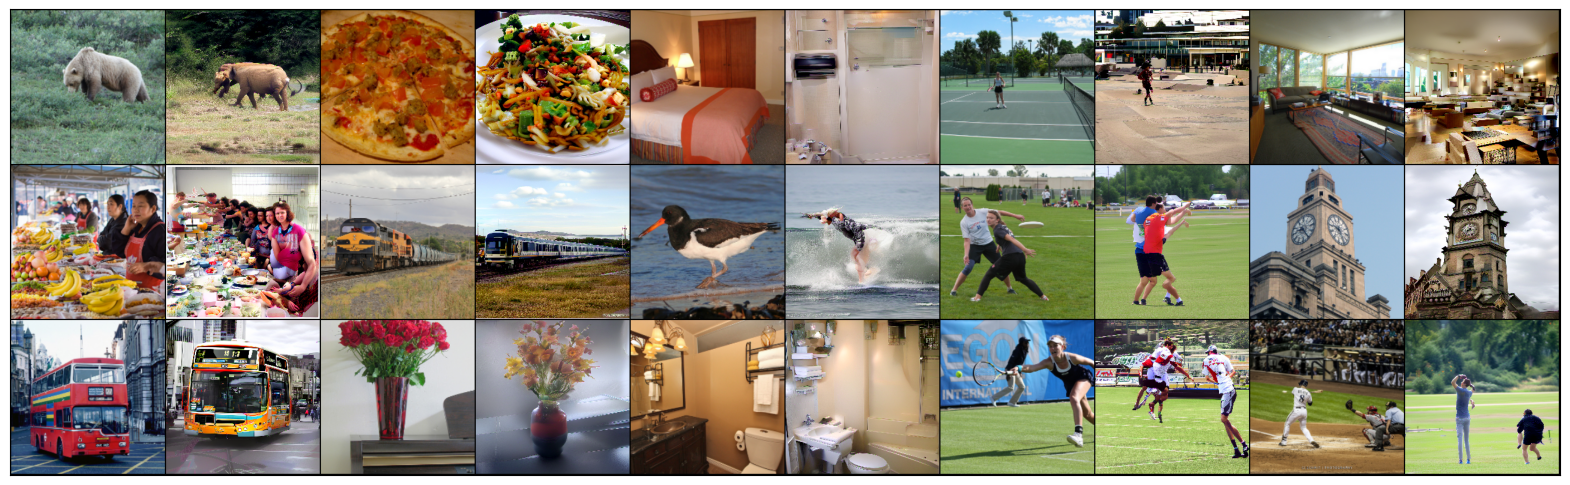

In [11]:
imsize = 256
all_images = transforms.Resize((imsize,imsize))(all_images)
all_recons = transforms.Resize((imsize,imsize))(all_recons)
print(all_images.shape, all_recons.shape)
np.random.seed(0)
ind = np.flip(np.array([112,119,101,44,159,22,173,174,175,189,981,243,249,255,265]))

all_interleaved = torch.zeros(len(ind)*2,3,imsize,imsize)
icount = 0
for t in ind:
    all_interleaved[icount] = all_images[t]
    all_interleaved[icount+1] = all_recons[t]
    icount += 2

plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs,figsize):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=figsize)
    for i, img in enumerate(imgs):
        print(img.shape)
        img = img.detach()
        img = transforms.ToPILImage()(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
grid = make_grid(all_interleaved, nrow=10, padding=2)
show(grid,figsize=(20,16))

## 2-way identification

In [4]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

@torch.no_grad()
def two_way_identification(all_recons, all_images, model, preprocess, feature_layer=None, return_avg=True):
    preds = model(torch.stack([preprocess(recon) for recon in all_recons], dim=0).to(device))
    reals = model(torch.stack([preprocess(indiv) for indiv in all_images], dim=0).to(device))
    if feature_layer is None:
        preds = preds.float().flatten(1).cpu().numpy()
        reals = reals.float().flatten(1).cpu().numpy()
    else:
        preds = preds[feature_layer].float().flatten(1).cpu().numpy()
        reals = reals[feature_layer].float().flatten(1).cpu().numpy()

    r = np.corrcoef(reals, preds)
    r = r[:len(all_images), len(all_images):]
    congruents = np.diag(r)

    success = r < congruents
    success_cnt = np.sum(success, 0)

    if return_avg:
        perf = np.mean(success_cnt) / (len(all_images)-1)
        return perf
    else:
        return success_cnt, len(all_images)-1

## PixCorr

In [5]:
preprocess = transforms.Compose([
    transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR),
])

# Flatten images while keeping the batch dimension
all_images_flattened = preprocess(all_images).reshape(len(all_images), -1).cpu()
all_recons_flattened = preprocess(all_recons).view(len(all_recons), -1).cpu()

print(all_images_flattened.shape)
print(all_recons_flattened.shape)

corrsum = 0
for i in tqdm(range(982)):
    corrsum += np.corrcoef(all_images_flattened[i], all_recons_flattened[i])[0][1]
corrmean = corrsum / 982

pixcorr = corrmean
print(pixcorr)

torch.Size([982, 541875])
torch.Size([982, 541875])


100%|██████████| 982/982 [00:03<00:00, 262.64it/s]

0.22891613331029645


## SSIM

In [6]:
# see https://github.com/zijin-gu/meshconv-decoding/issues/3
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim

preprocess = transforms.Compose([
    transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR), 
])

# convert image to grayscale with rgb2grey
img_gray = rgb2gray(preprocess(all_images).permute((0,2,3,1)).cpu())
recon_gray = rgb2gray(preprocess(all_recons).permute((0,2,3,1)).cpu())
print("converted, now calculating ssim...")

ssim_score=[]
for im,rec in tqdm(zip(img_gray,recon_gray),total=len(all_images)):
    ssim_score.append(ssim(rec, im, multichannel=True, gaussian_weights=True, sigma=1.5, use_sample_covariance=False, data_range=1.0))

ssim = np.mean(ssim_score)
print(ssim)

/export/raid1/home/kneel027/miniconda3/envs/mindeye_clone/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


converted, now calculating ssim...


100%|██████████| 982/982 [00:10<00:00, 92.62it/s]

0.31838165234904797


## AlexNet

In [9]:
from torchvision.models import alexnet, AlexNet_Weights
alex_weights = AlexNet_Weights.IMAGENET1K_V1

alex_model = create_feature_extractor(alexnet(weights=alex_weights), return_nodes=['features.4','features.11']).to(device)
alex_model.eval().requires_grad_(False)

# see alex_weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

layer = 'early, AlexNet(2)'
print(f"\n---{layer}---")
all_per_correct = two_way_identification(all_recons.to(device).float(), all_images, 
                                                          alex_model, preprocess, 'features.4')
alexnet2 = np.mean(all_per_correct)
print(f"2-way Percent Correct: {alexnet2:.4f}")

layer = 'mid, AlexNet(5)'
print(f"\n---{layer}---")
all_per_correct = two_way_identification(all_recons.to(device).float(), all_images, 
                                                          alex_model, preprocess, 'features.11')
alexnet5 = np.mean(all_per_correct)
print(f"2-way Percent Correct: {alexnet5:.4f}")

NameError: name 'create_feature_extractor' is not defined

## InceptionV3

In [ ]:
from torchvision.models import inception_v3, Inception_V3_Weights
weights = Inception_V3_Weights.DEFAULT
inception_model = create_feature_extractor(inception_v3(weights=weights), 
                                           return_nodes=['avgpool']).to(device)
inception_model.eval().requires_grad_(False)

# see weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(342, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

all_per_correct = two_way_identification(all_recons, all_images,
                                        inception_model, preprocess, 'avgpool')
        
inception = np.mean(all_per_correct)
print(f"2-way Percent Correct: {inception:.4f}")

## CLIP

In [ ]:
import clip
clip_model, preprocess = clip.load("ViT-L/14", device=device)

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711]),
])

all_per_correct = two_way_identification(all_recons, all_images,
                                        clip_model.encode_image, preprocess, None) # final layer
clip_ = np.mean(all_per_correct)
print(f"2-way Percent Correct: {clip_:.4f}")

## Efficient Net

In [ ]:
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
weights = EfficientNet_B1_Weights.DEFAULT
eff_model = create_feature_extractor(efficientnet_b1(weights=weights), 
                                    return_nodes=['avgpool']).to(device)
eff_model.eval().requires_grad_(False)

# see weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(255, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

gt = eff_model(preprocess(all_images))['avgpool']
gt = gt.reshape(len(gt),-1).cpu().numpy()
fake = eff_model(preprocess(all_recons))['avgpool']
fake = fake.reshape(len(fake),-1).cpu().numpy()

effnet = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
print("Distance:",effnet)

## SwAV

In [ ]:
swav_model = torch.hub.load('facebookresearch/swav:main', 'resnet50')
swav_model = create_feature_extractor(swav_model, 
                                    return_nodes=['avgpool']).to(device)
swav_model.eval().requires_grad_(False)

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

gt = swav_model(preprocess(all_images))['avgpool']
gt = gt.reshape(len(gt),-1).cpu().numpy()
fake = swav_model(preprocess(all_recons))['avgpool']
fake = fake.reshape(len(fake),-1).cpu().numpy()

swav = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
print("Distance:",swav)

# Brain Correlations

In [12]:
# Load brain region masks
brain_region_masks = {}
with h5py.File("src/evals/brain_region_masks.hdf5", "r") as file:
    # Iterate over each subject
    for subject in file.keys():
        subject_group = file[subject]
        # Load the masks data for each subject
        subject_masks = {"nsd_general" : subject_group["nsd_general"][:],
                         "early_vis" : subject_group["early_vis"][:], 
                         "higher_vis" : subject_group["higher_vis"][:], 
                         "V1" : subject_group["V1"][:], 
                         "V2" : subject_group["V2"][:], 
                         "V3" : subject_group["V3"][:], 
                         "V4" : subject_group["V4"][:]}
        brain_region_masks[subject] = subject_masks
subject_masks = brain_region_masks[f"subj0{subj}"]
# Average voxels of test set across trial repetitions for brain correlation scores
test_voxels_averaged = torch.zeros((len(np.unique(test_images_idx)),num_voxels))
i = 0
for batch in range(0,len(np.unique(test_images_idx)),minibatch_size):
    uniq_imgs = np.unique(test_images_idx)[batch:batch+minibatch_size]
    for uniq_img in uniq_imgs:
        locs = np.where(test_images_idx==uniq_img)[0]
        if len(locs)==1:
            locs = locs.repeat(3)
        elif len(locs)==2:
            locs = locs.repeat(2)[:3]
        assert len(locs)==3
        test_voxels_averaged[i] = torch.mean(test_voxels[None,locs], dim=1)
        i+=1

# Prepare image list for input to GNet
image_list = []
for i in range(all_recons.shape[0]):
    img = all_recons[i].detach()
    img = transforms.ToPILImage()(img)
    image_list.append(img)


In [13]:
# Load GNet encoding model for current subject
reese_beta_primes = torch.load(f"subj1_beta_primes.pt")
reese_betas = torch.load(f"subj1test_norm5.pt")
image_list = []
for i in range(982):
    img = all_images[i].detach()
    img = transforms.ToPILImage()(img)
    image_list.append(img)
GNet = GNet8_Encoder(device=device,subject=subj, model_path="src/gnet_multisubject.pt")
PeC = PearsonCorrCoef(num_outputs=982)
beta_primes = GNet.predict(image_list)
subject_masks = brain_region_masks[f"subj0{subj}"]
# Calcaulate the pearson correlation for each region of the brain.
# print(test_voxels_averaged, beta_primes.shape)
region_brain_correlations = {}
# Calculate brain predictions
# for region, mask in subject_masks.items():
# PeC = PearsonCorrCoef()
# for i in range(982):
# score = PeC(test_voxels_averaged.moveaxis(0,1), beta_primes.moveaxis(0,1))
score = PeC(reese_betas.moveaxis(0,1), beta_primes.moveaxis(0,1))
print(torch.mean(score))
    # print(torch.mean(scores))
    # region_brain_correlations[region] = torch.mean(scores)

tensor(0.4220)


In [92]:

GNet = GNet8_Encoder(device=device,subject=subj)
PeC = PearsonCorrCoef(num_outputs=len(image_list))
beta_primes = GNet.predict(image_list)

region_brain_correlations = {}
for region, mask in subject_masks.items():
    score = PeC(test_voxels_averaged[:,mask].moveaxis(0,1), beta_primes[:,mask].moveaxis(0,1))
    region_brain_correlations[region] = torch.mean(score)
print(region_brain_correlations)
    

{'nsd_general': tensor(0.3611), 'early_vis': tensor(0.3699), 'higher_vis': tensor(0.3388), 'V1': tensor(0.3669), 'V2': tensor(0.3712), 'V3': tensor(0.3663), 'V4': tensor(0.3386)}


## Display in table

In [ ]:
# Create a dictionary to store variable names and their corresponding values
data = {
    "Metric": ["PixCorr", "SSIM", "AlexNet(2)", "AlexNet(5)", "InceptionV3", "CLIP", "EffNet-B", "SwAV"],
    "Value": [pixcorr, ssim, alexnet2, alexnet5, inception, clip_, effnet, swav],
}

df = pd.DataFrame(data)
print(df.to_string(index=False))

# save table to txt file
os.makedirs('tables/',exist_ok=True)
df.to_csv(f'tables/{recon_path[:-3]}.csv', sep='\t', index=False)